# Analyze A/B Test Results 


- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)



<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. This project utilized A/B testing to determine if an e-commerce website had greater sales when consumers were presented with an old webpage or a new webpage. To assist the e-commerce company in decision-making, this project will compare the conversion rate of individuals who decided to purchase products based on which webpage they visited, new or old. This project will include probability testing, a/b hypothesis testing, and regression modeling to determine the best decision for the e-commerce company to make to increase sales.





<a id='probability'></a>
## Part I - Probability



In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

Below is the description of the dataset from the e-commerce company, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>


In [2]:
#Importing dataset
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
# Number of rows in dataset
df.shape[0]

294478

In [4]:
# Number of unique users in dataset
df.user_id.nunique()

290584

In [5]:
# Proportion of users who converted (i.e. purchased from website)
df.converted.mean()

0.11965919355605512

In [6]:
# The number of times when the "group" is treatment but "landing_page" is not a new_page.
(df.query('group == "treatment"')['landing_page'] != 'new_page').sum()

1965

In [7]:
# Checking for missing values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [8]:
# Making copy of dataset before removing inaccurate rows
df2 = df.copy()

In [9]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2.drop(df2[(df2['group'] == "control") & (df2['landing_page'] == "new_page")].index, inplace=True)
df2.drop(df2[(df2['group'] == "treatment") & (df2['landing_page'] == "old_page")].index, inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [10]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [11]:
# Number of unique users
df2.user_id.nunique()

290584

In [12]:
# Checking for duplicate users
df2[df2.duplicated('user_id')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [13]:
# Duplicate user found
dup = df2[df2.user_id.duplicated(keep=False)]
dup

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [14]:
# Remove one of the rows with a duplicate user_id.. 
df2.drop([2893], axis=0, inplace=True)

# Check again if the row with a duplicate user_id is deleted or not
df2[df2.duplicated('user_id')]

,user_id,timestamp,group,landing_page,converted


In [15]:
# Overall converted success rate
p_pop = df2.converted.mean()
p_pop

0.11959708724499628

In [16]:
#Probability individual in control group converted
p_control = df2.query('group == "control"')['converted'].mean()
p_control

0.1203863045004612

In [17]:
#Probability individual in treatment group converted
p_tx = df2.query('group == "treatment"')['converted'].mean()
p_tx

0.11880806551510564

In [18]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = p_tx - p_control
obs_diff

-0.0015782389853555567

In [19]:
# Probability individual received the new webpage
p_new_page = df2.query('landing_page == "new_page"')['landing_page'].count() / df2.shape[0]
p_new_page

0.50006194422266881

Based on the above analysis, users within the control group converted 12% of the time and users within the treatment group converted 11.88% of the time. When analyzing the differences between conversion rates, the observed difference suggests users receiving the control (old webpage) were slightly more likely to purchase sales than users receiving the treatment (new webpage). It does not appear that users within the treatment group led to more conversions.

<a id='ab_test'></a>
## Part II - A/B Test

For the A/B Test to determine if the e-commerce company has increased sales with the new webpage versus the old webpage, two hypotheses must be determined. The Null Hypothesis for this project will assume there is no difference in sales (conversion) between the new webpage and the old webpage. In other words, the Null Hypothesis shall state that the old webpage had equal to or greater sales than the new webpage. For our alternative hypothesis, we are trying to disprove the null hypothesis. Therefore, the alternative hypothesis for this project is defined as the new webpage having greater sales than the old webpage.

Null: $P{old}$ >= $P{new}$

Alt: $P{old}$ < $P{new}$

In [20]:
# Conversion rate for Probability of new webpage under null
p_new = df2.converted.mean()
p_new

0.11959708724499628

In [21]:
# Conversion rate for probability of old webpage under null
p_old = df2.converted.mean()
p_old

0.11959708724499628

In [22]:
# Number of individuals shown the new webpage
n_new = df2.query('group == "treatment"')['user_id'].count()
n_new

145310

In [23]:
# Number of individuals shown the old webpage
n_old = df2.query('group == "control"')['user_id'].count()
n_old

145274

In [24]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([0,1], n_new, replace=True, p=[p_new, 1-p_new]).mean()
new_page_converted

0.87995320349597417

In [25]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([0, 1], n_old, replace=True, p=[p_old, 1-p_old]).mean()
old_page_converted

0.88185773090849018

In [26]:
# Difference in probability between old and new webpage
p_converted = new_page_converted - old_page_converted
p_converted

-0.0019045274125160105

In [27]:
# Sampling distribution 
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([0,1], n_new, replace=True, p=[p_new, 1-p_new]).mean()
    old_page_converted = np.random.choice([0, 1], n_old, replace=True, p=[p_old, 1-p_old]).mean()
    p_diffs.append(new_page_converted - old_page_converted)

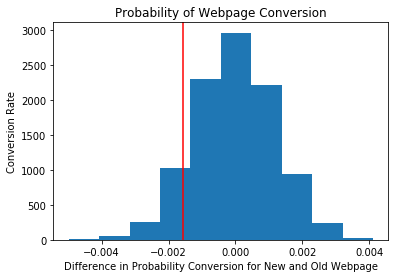

In [28]:
# Histogram plot of difference in probability 
p_diffs = np.array(p_diffs)
plt.hist(p_diffs);
plt.axvline(x=obs_diff, color='r');
plt.title('Probability of Webpage Conversion')
plt.xlabel('Difference in Probability Conversion for New and Old Webpage')
plt.ylabel('Conversion Rate');

In [29]:
# Proportion of p_diffs greater than the actual difference
p_val = (p_diffs > obs_diff).mean()
p_val

0.90349999999999997

The above calculation is called a p-value. It is the probabilty that a sample mean will be more extreme than the observed mean within the null distribution. When comparing the above p-value to our Type I error rate of 0.05, it is likely our sample mean came from the null distribution, indicating our Null hypothesis is likely true, thus we fail to reject the null hypothesis. This means there is no observed difference between the new and old webpages and conversion rates.

In [30]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query('landing_page == "old_page" and converted == 1')['user_id'].count()

# number of conversions with the new_page
convert_new = df2.query('landing_page == "new_page" and converted == 1')['user_id'].count()

# number of individuals who were shown the old_page
n_old = df2.query('landing_page == "old_page"')['user_id'].count()

# number of individuals who received new_page
n_new = df2.query('landing_page == "new_page"')['user_id'].count()

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [31]:
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. 
>Hint:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 


In other words, we determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. A "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.



Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

---

>**Tip**: You don't have to dive deeper into z-test for this exercise. **Try having an overview of what does z-score signify in general.** 

In [32]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
count_array = np.array([convert_new, convert_old])
nobs_array = np.array([n_new, n_old])
z_score, p_value = sm.stats.proportions_ztest(count_array, nobs_array, alternative='larger')
print(z_score, p_value)


-1.31092419842 0.905058312759


Based on the Z score of the above analysis, our calculated Z-score of -1.31 is less than the Z-aplha score of 1.645. A Z-score less than the Z-aplha score obtained during right-tailed test indicates a failure to reject the null hypothesis. This is congruent with the obtained p-value of 0.905 which is greater than the aplha of 0.05, further indicating a failure to reject the null hypothesis. The results of this analysis indicate there is no significant difference of conversion rates between the old and new webpages.

<a id='regression'></a>
### Part III - A regression approach



This analysis is comparing two webpages, old and new, to determine the likelihood of an individual converting or not converting. These variables are categorical, not quantitative. When comparing categorical data, a logistic regression is used.

In [33]:
# Creating intercept and dummy variables for model
df2['intercept'] = 1
df2[['control','ab_page']] = pd.get_dummies(df2['group'])
df2 = df2.drop('control', axis=1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [34]:
# Creating log model
import statsmodels.api as sm

log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [35]:
# Logistical Regression Model Summary
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-10-18 15:57 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

Per the logistic regression model, the coefficient associated with the conversion of individuals receiving the treatment was -0.0150. This suggests that with each individual receiving the treatment, there is a decreased likelihood the individual will convert. This further supports previous p-values obtained during simulation and Z-testing (p-value of 0.90). When we compare these p-values to a Type I error rate of 0.05, we fail to reject the Null hypothesis that the old webpage has an equal or greater conversion rate than the new webpage. Overall, simulation testing, hypothesis testing, and logistical regression testing support a Fail to Reject the Null Hypothesis conclusion.

Other reasons individuals may not have converted are varied and may include demographic factors such as income, employment, gender, age, educational level, etc. We could also analyze the amount of time spent on the webpage before converting to see if there is a correlation between longer time durations viewing the webpage and conversion rate. However, increasing the number of factors for comparison could result in decreased or skewed accuracy. Multicollinearity between factors may produce misleading results.

In [36]:
# Comparing US conversion rate to conversion rate in other countries
# Read the countries.csv
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [37]:
# Join with the df2 dataframe
df_merged = pd.merge(df2, countries, on='user_id')
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [38]:
# Create the necessary dummy variables
df_merged[['US', 'UK', 'CA']] = pd.get_dummies(df_merged['country'])
df_merged = df_merged.drop('country', axis=1)
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,US,UK,CA
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0,0,1


**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 

>**Tip**: Conclusions should include both statistical reasoning, and practical reasoning for the situation. 

>**Hints**: 
- Look at all of p-values in the summary, and compare against the Type I error rate (0.05). 
- Can you reject/fail to reject the null hypotheses (regression model)?
- Comment on the effect of page and country to predict the conversion.


In [39]:
# Fit your model, and summarize the results
df_merged['intercept'] = 1
log_mod = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'UK', 'CA']])
res = log_mod.fit()
res.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-10-18 15:57 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
CA             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
==================================================================

"""

In [40]:
# Multiplicative change in the odds regarding coefficients
np.exp(res.params)

intercept    0.131332
ab_page      0.985168
UK           1.051944
CA           1.041599
dtype: float64

In [41]:
# Checking inverse for coefficients less than 1
1 / np.exp(res.params)

intercept    7.614303
ab_page      1.015056
UK           0.950621
CA           0.960062
dtype: float64

In [42]:
#Interaction between country and treatment on conversion
df_merged['UK_ab_page'] = df_merged['UK']*df_merged['ab_page']
df_merged['CA_ab_page'] = df_merged['CA']*df_merged['ab_page']
df_merged['US_ab_page'] = df_merged['US']*df_merged['ab_page']
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,US,UK,CA,UK_ab_page,CA_ab_page,US_ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0,0,1,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0,0,1,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,0,1,0,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,0,1,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0,0,1,0,0,0


In [43]:
#Log Model looking at country and treatment on conversion
log_mod2 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'UK_ab_page', 'CA_ab_page']])
res2 = log_mod2.fit()
res2.summary2()

Optimization terminated successfully.
         Current function value: 0.366117
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-10-18 15:57 AIC:              212781.7674
No. Observations:   290584           BIC:              212813.5064
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9926    0.0079  -252.9104  0.0000  -2.0081  -1.9772
UK_ab_page    0.0112    0.0179     0.6256  0.5316  -0.0240   0.0464
CA_ab_page   -0.0144    0.0125    -1.1548  0.2482  -0.0389   0.0101
==================================================================

"""

In [44]:
# Multiplicative change in the odds regarding coefficients
np.exp(res2.params)

intercept     0.136338
UK_ab_page    1.011292
CA_ab_page    0.985679
dtype: float64

In [45]:
# Checking inverse for coefficients less than 1
1/np.exp(res2.params)

intercept     7.334699
UK_ab_page    0.988834
CA_ab_page    1.014530
dtype: float64

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])